<br> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="80" width="150" align="Center" /> <br>
    
<br>
<center> <h2>Maestría en Inteligencia Analítica para la Toma de Decisiones</h2> </center>
<br>

##### Presentado por:

    Arturo Guerrero            (201823464)
    Carlos Andres Paez Rojas   (201924257)     

<h4> Octubre 2020 </h4>
<br>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [2]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=0.9)

rcParams['figure.figsize'] = 22, 10


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [3]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [100]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [5]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [22]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

Veamos el primer comentario de entrenamiento que es positivo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [8]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [9]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

In [10]:
# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

In [11]:
# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

In [12]:
# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

In [13]:
# Guardamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_v < err_v):
        pathr =('BRNN_part='+str(i)+'_seed_'+str(r)+'.h5')
        model.save(pathr) 
        err_v = loss_v
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    print('Loss : loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 94s 8ms/step - loss: 0.4509 - accuracy: 0.7798 - val_loss: 0.3507 - val_accuracy: 0.8518
Epoch 2/3
12500/12500 [==============================] - 92s 7ms/step - loss: 0.2211 - accuracy: 0.9164 - val_loss: 0.3625 - val_accuracy: 0.8434
Epoch 3/3
12500/12500 [==============================] - 94s 8ms/step - loss: 0.1143 - accuracy: 0.9609 - val_loss: 0.4812 - val_accuracy: 0.8465
Desempeño (exactitud): accu_v1=0.8464800119400024 , accu_v2=0.8360400199890137
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 102s 8ms/step - loss: 0.3207 - accuracy: 0.8757 - val_loss: 0.2684 - val_accuracy: 0.9008
Epoch 2/3
12500/12500 [==============================] - 98s 8ms/step - loss: 0.1496 - accuracy: 0.9482 - val_loss: 0.2838 - val_accuracy: 0.

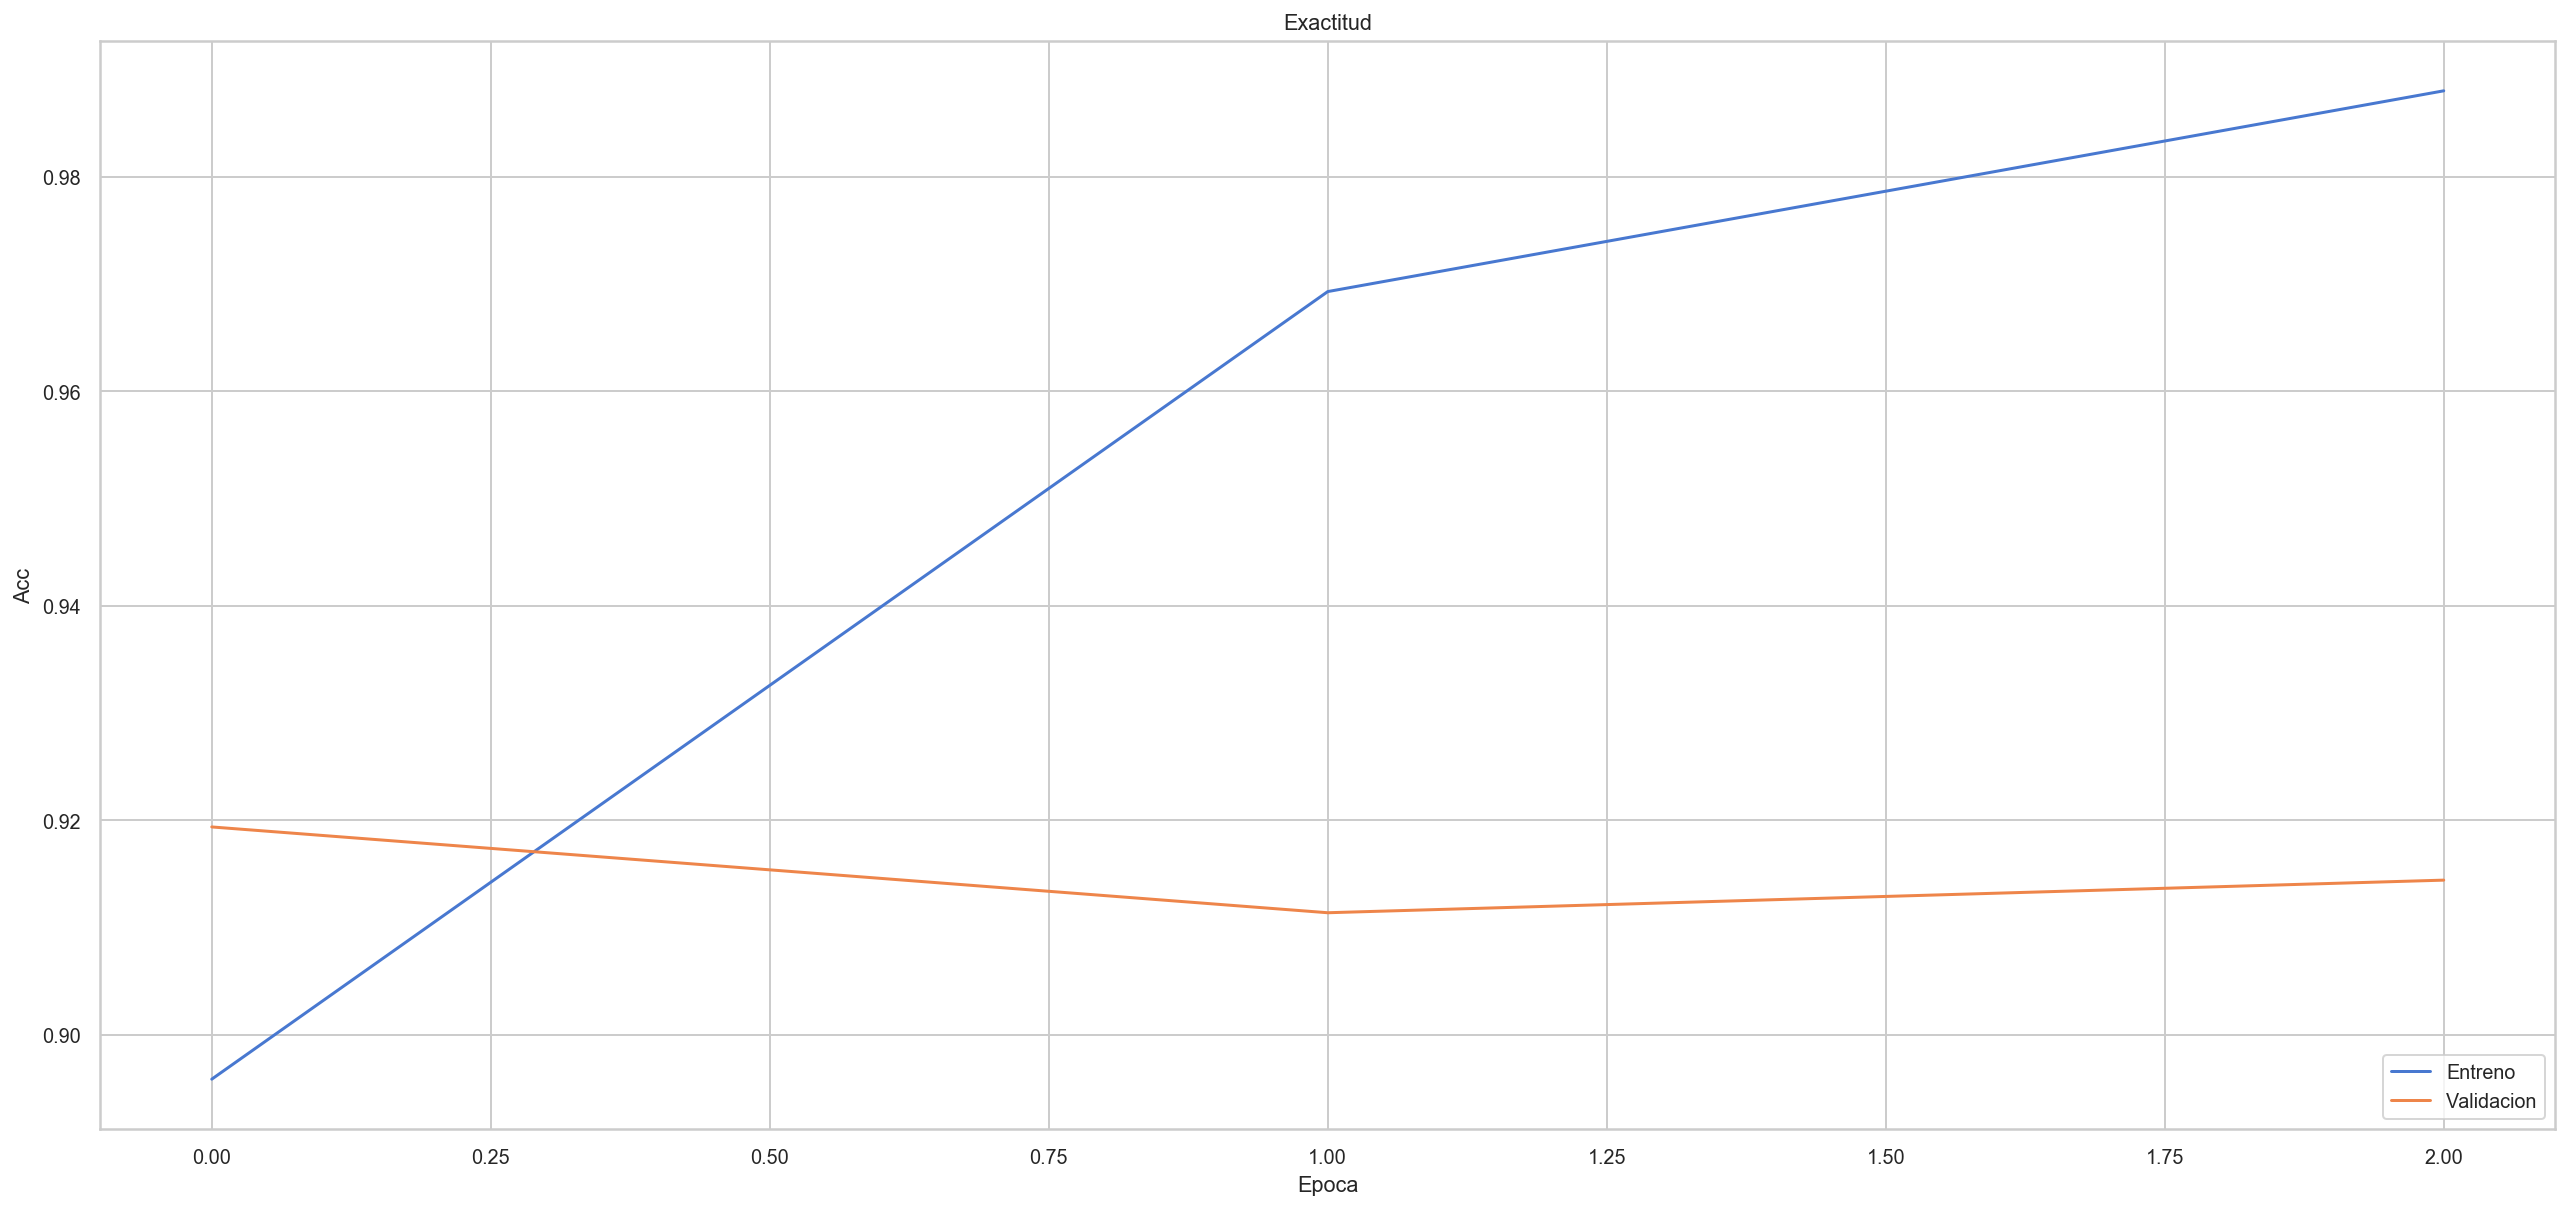

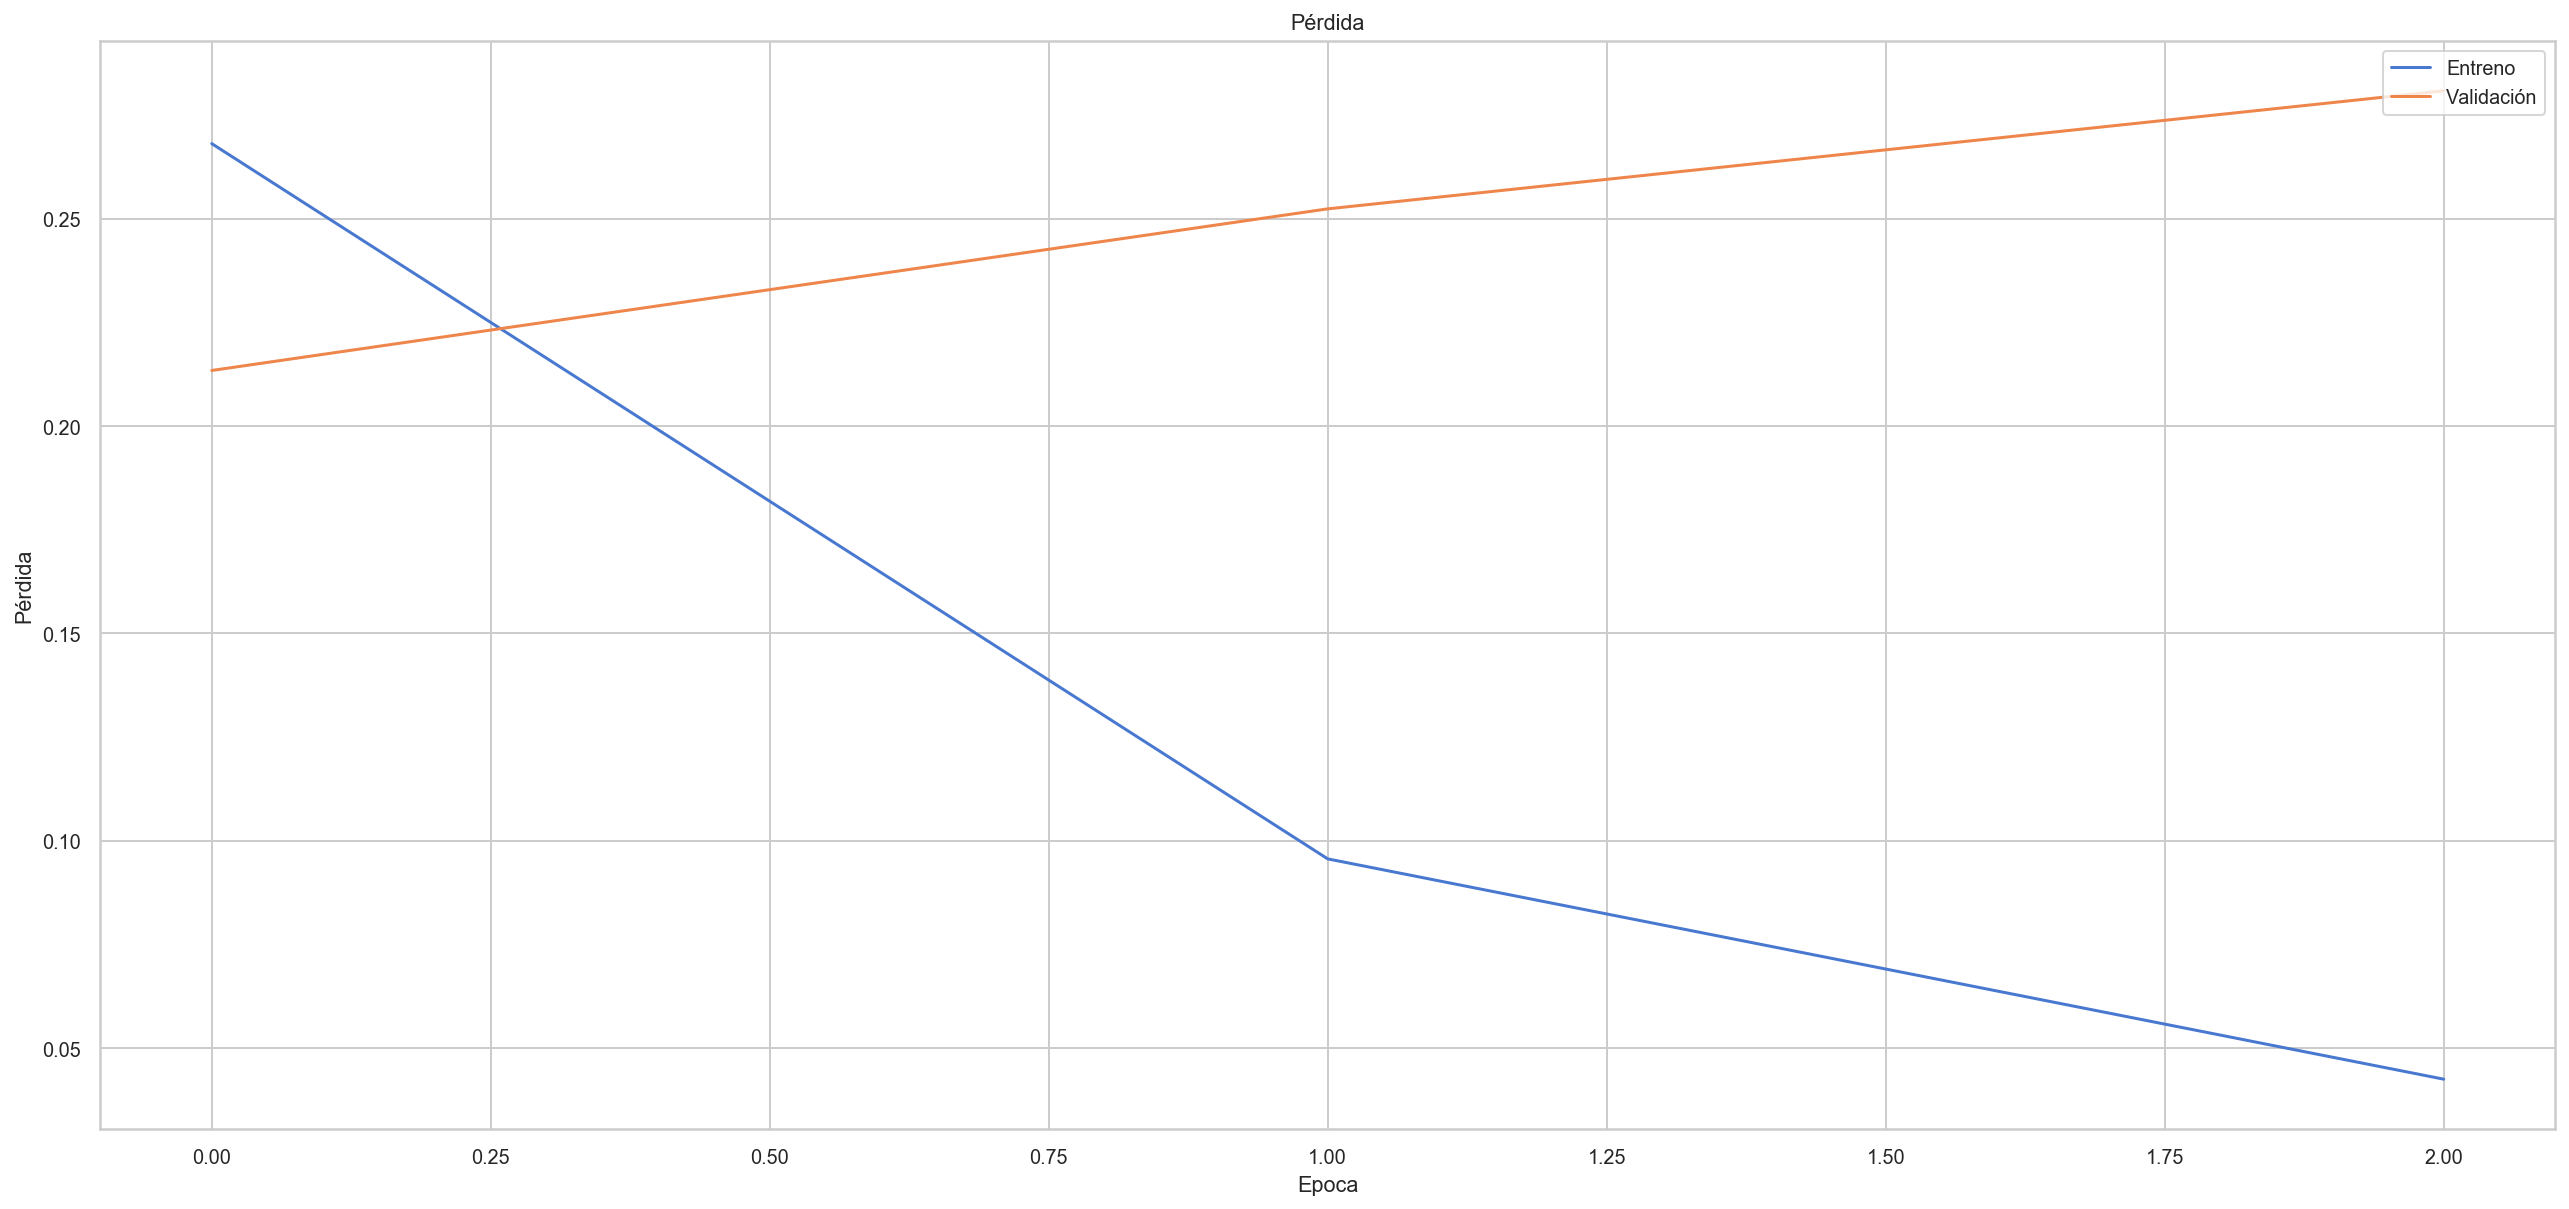

In [16]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [17]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=0_seed_3.h5')

model_brnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [18]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11001  1499]
 [  709 11791]]
Exactitud:  0.9116799831390381


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [19]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9824  2676]
 [ 1423 11077]]
Exactitud:  0.8360400199890137


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [20]:
# Input con secuencias de enteros con longitud variable
inputs_ud = keras.Input(shape=(None,), dtype="int32")

In [21]:
# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x_ud = layers.Embedding(max_features, 128)(inputs_ud)

In [22]:
# Añadimos 2 capas LSTM bidireccionales de 64 unidades
x_ud = layers.LSTM(64, return_sequences=True)(x_ud)
x_ud = layers.LSTM(64)(x_ud)

In [23]:
# Añadimos un clasificador binario en la salida
outputs_ud = layers.Dense(1, activation="sigmoid")(x_ud)

In [24]:
# Guardamos la arquitectura del modelo
model_2 = keras.Model(inputs_ud, outputs_ud)
model_2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_v = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_2 = keras.Model(inputs, outputs)
    model_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_2.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model_2.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_2.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_2.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    #if (loss_v < err_v):
    pathr =('URNN_part='+str(i)+'_seed_'+str(r)+'.h5')
    model_2.save(pathr) 
    err_v = loss_v
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    print('Loss : loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)



Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 97s 8ms/step - loss: 0.1202 - accuracy: 0.9582 - val_loss: 0.1477 - val_accuracy: 0.9502
Epoch 2/3
12500/12500 [==============================] - 96s 8ms/step - loss: 0.0530 - accuracy: 0.9836 - val_loss: 0.1719 - val_accuracy: 0.9452
Epoch 3/3
12500/12500 [==============================] - 96s 8ms/step - loss: 0.0253 - accuracy: 0.9930 - val_loss: 0.1911 - val_accuracy: 0.9407
Desempeño (exactitud): accu_v1=0.9407200217247009 , accu_v2=0.8442800045013428
Loss : loss_v1=0.19110197345256805 , loss_v2=0.521477857439518
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 104s 8ms/step - loss: 0.1137 - accuracy: 0.9600 - val_loss: 0.1657 - val_accuracy: 0.9420
Epoch 2/3
12500/12500 [==============================] - 103s 8ms/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.1994 - val_accuracy: 0.9416
Epoch 3/3
12500/12500 [===

El modelo con mayor exactitud sobre la base de pruebas fue el último con un accuracy de 0.847, sin embargo, al comparar la perdida entre los dos set de validación, se observa que se está sobre ajustando a los datos de entrenamiento.

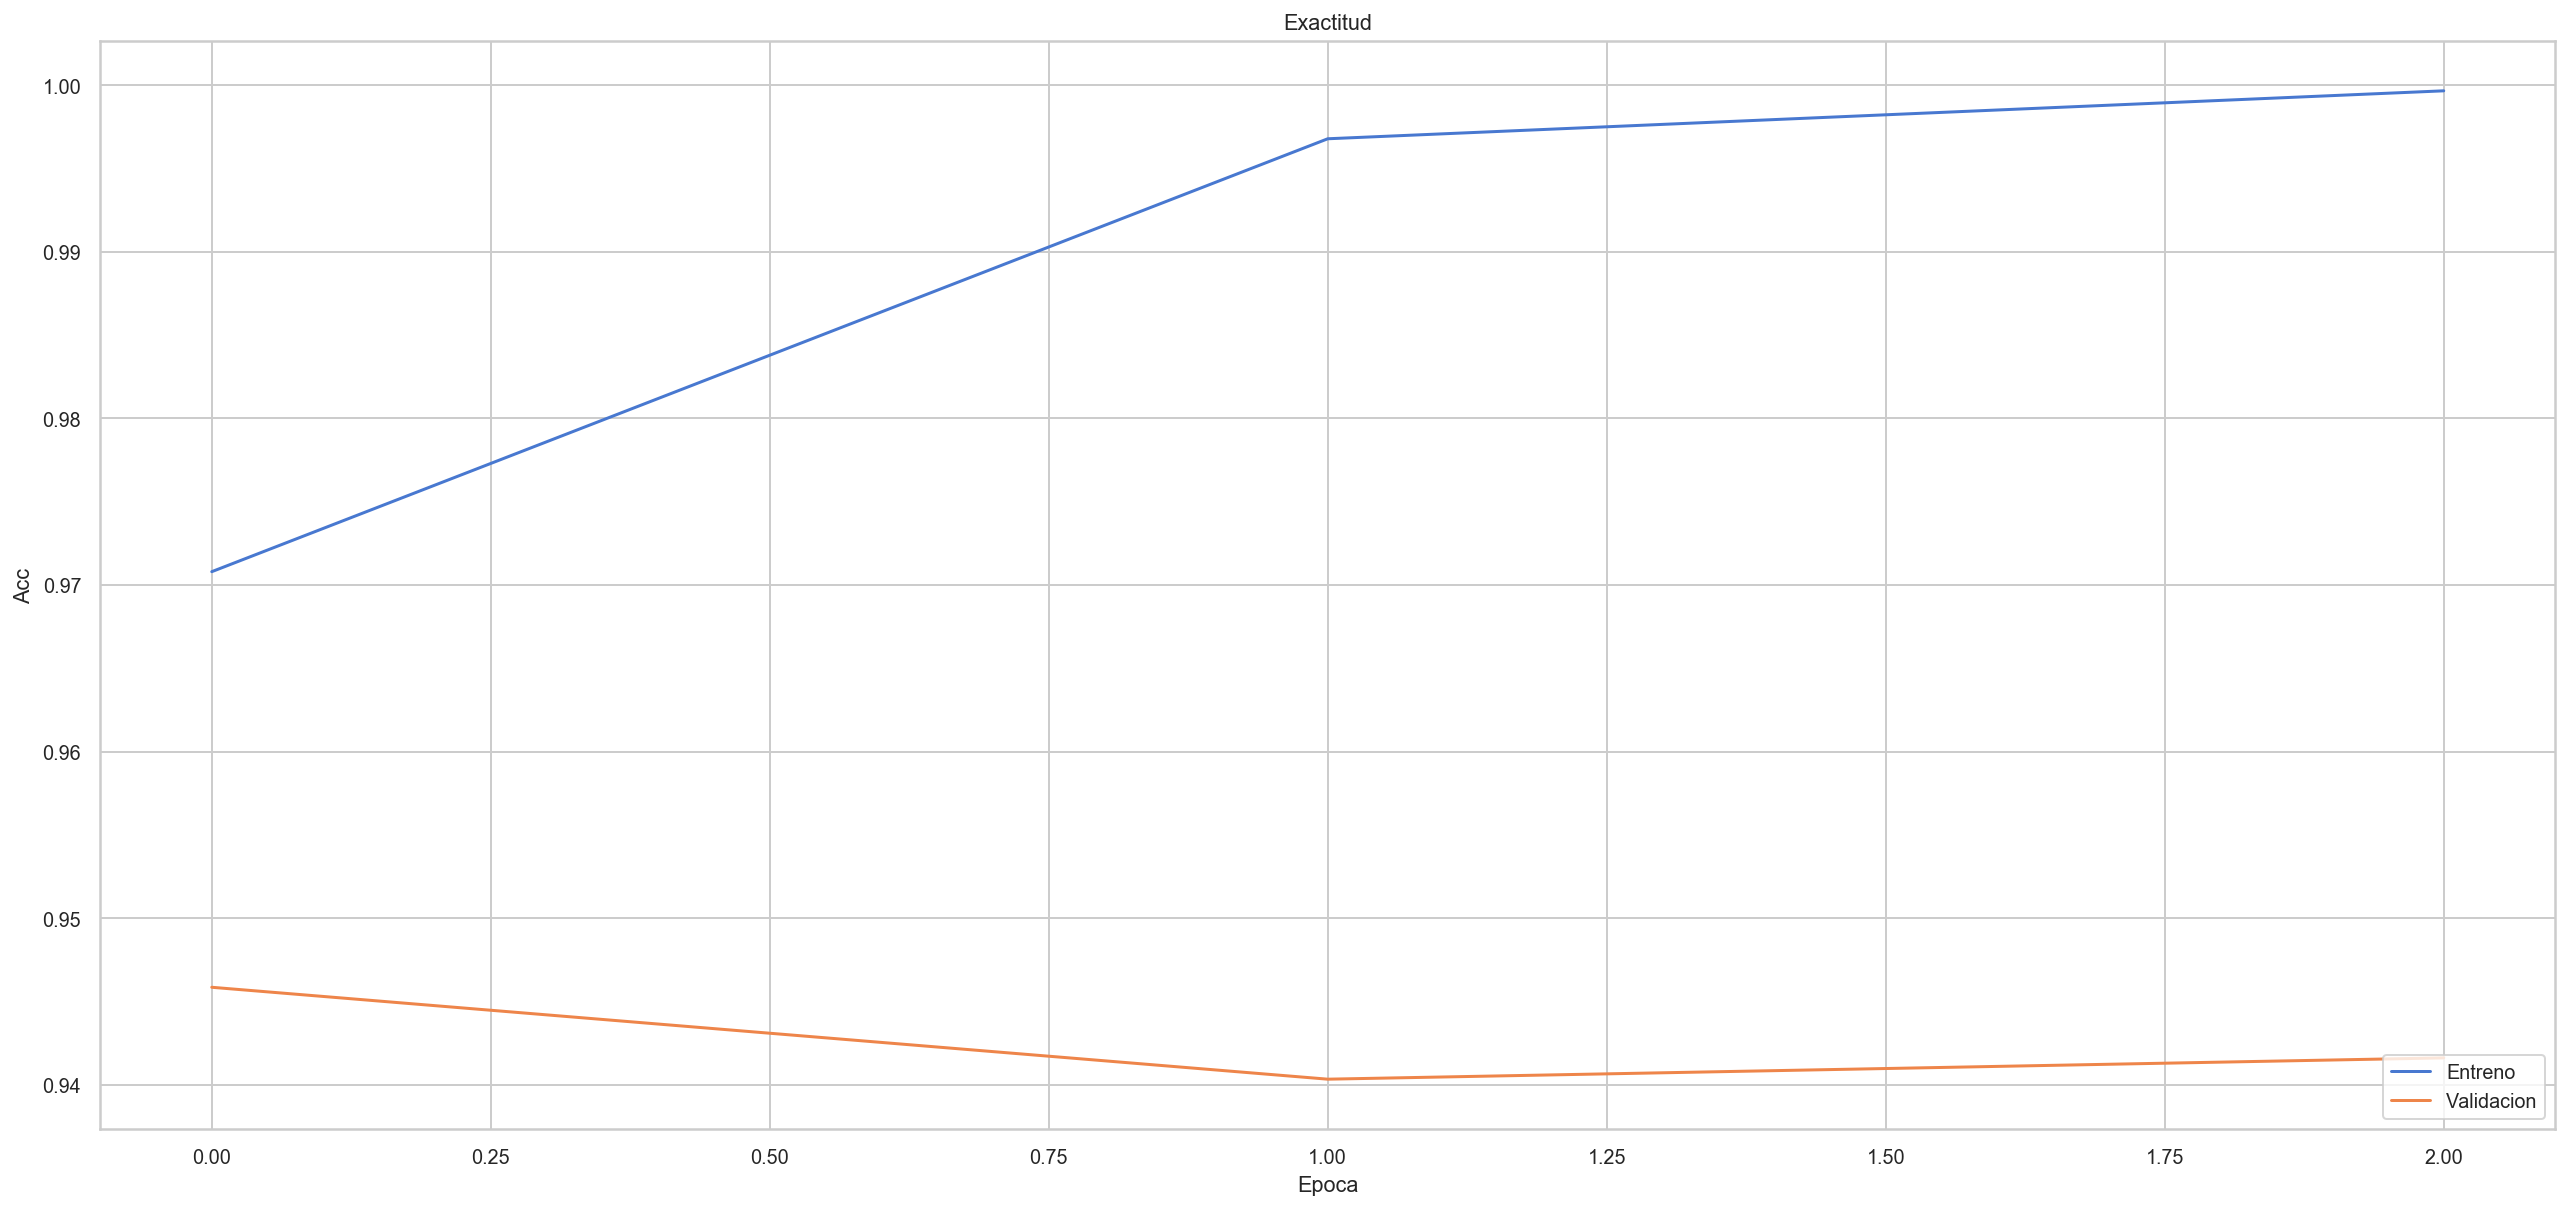

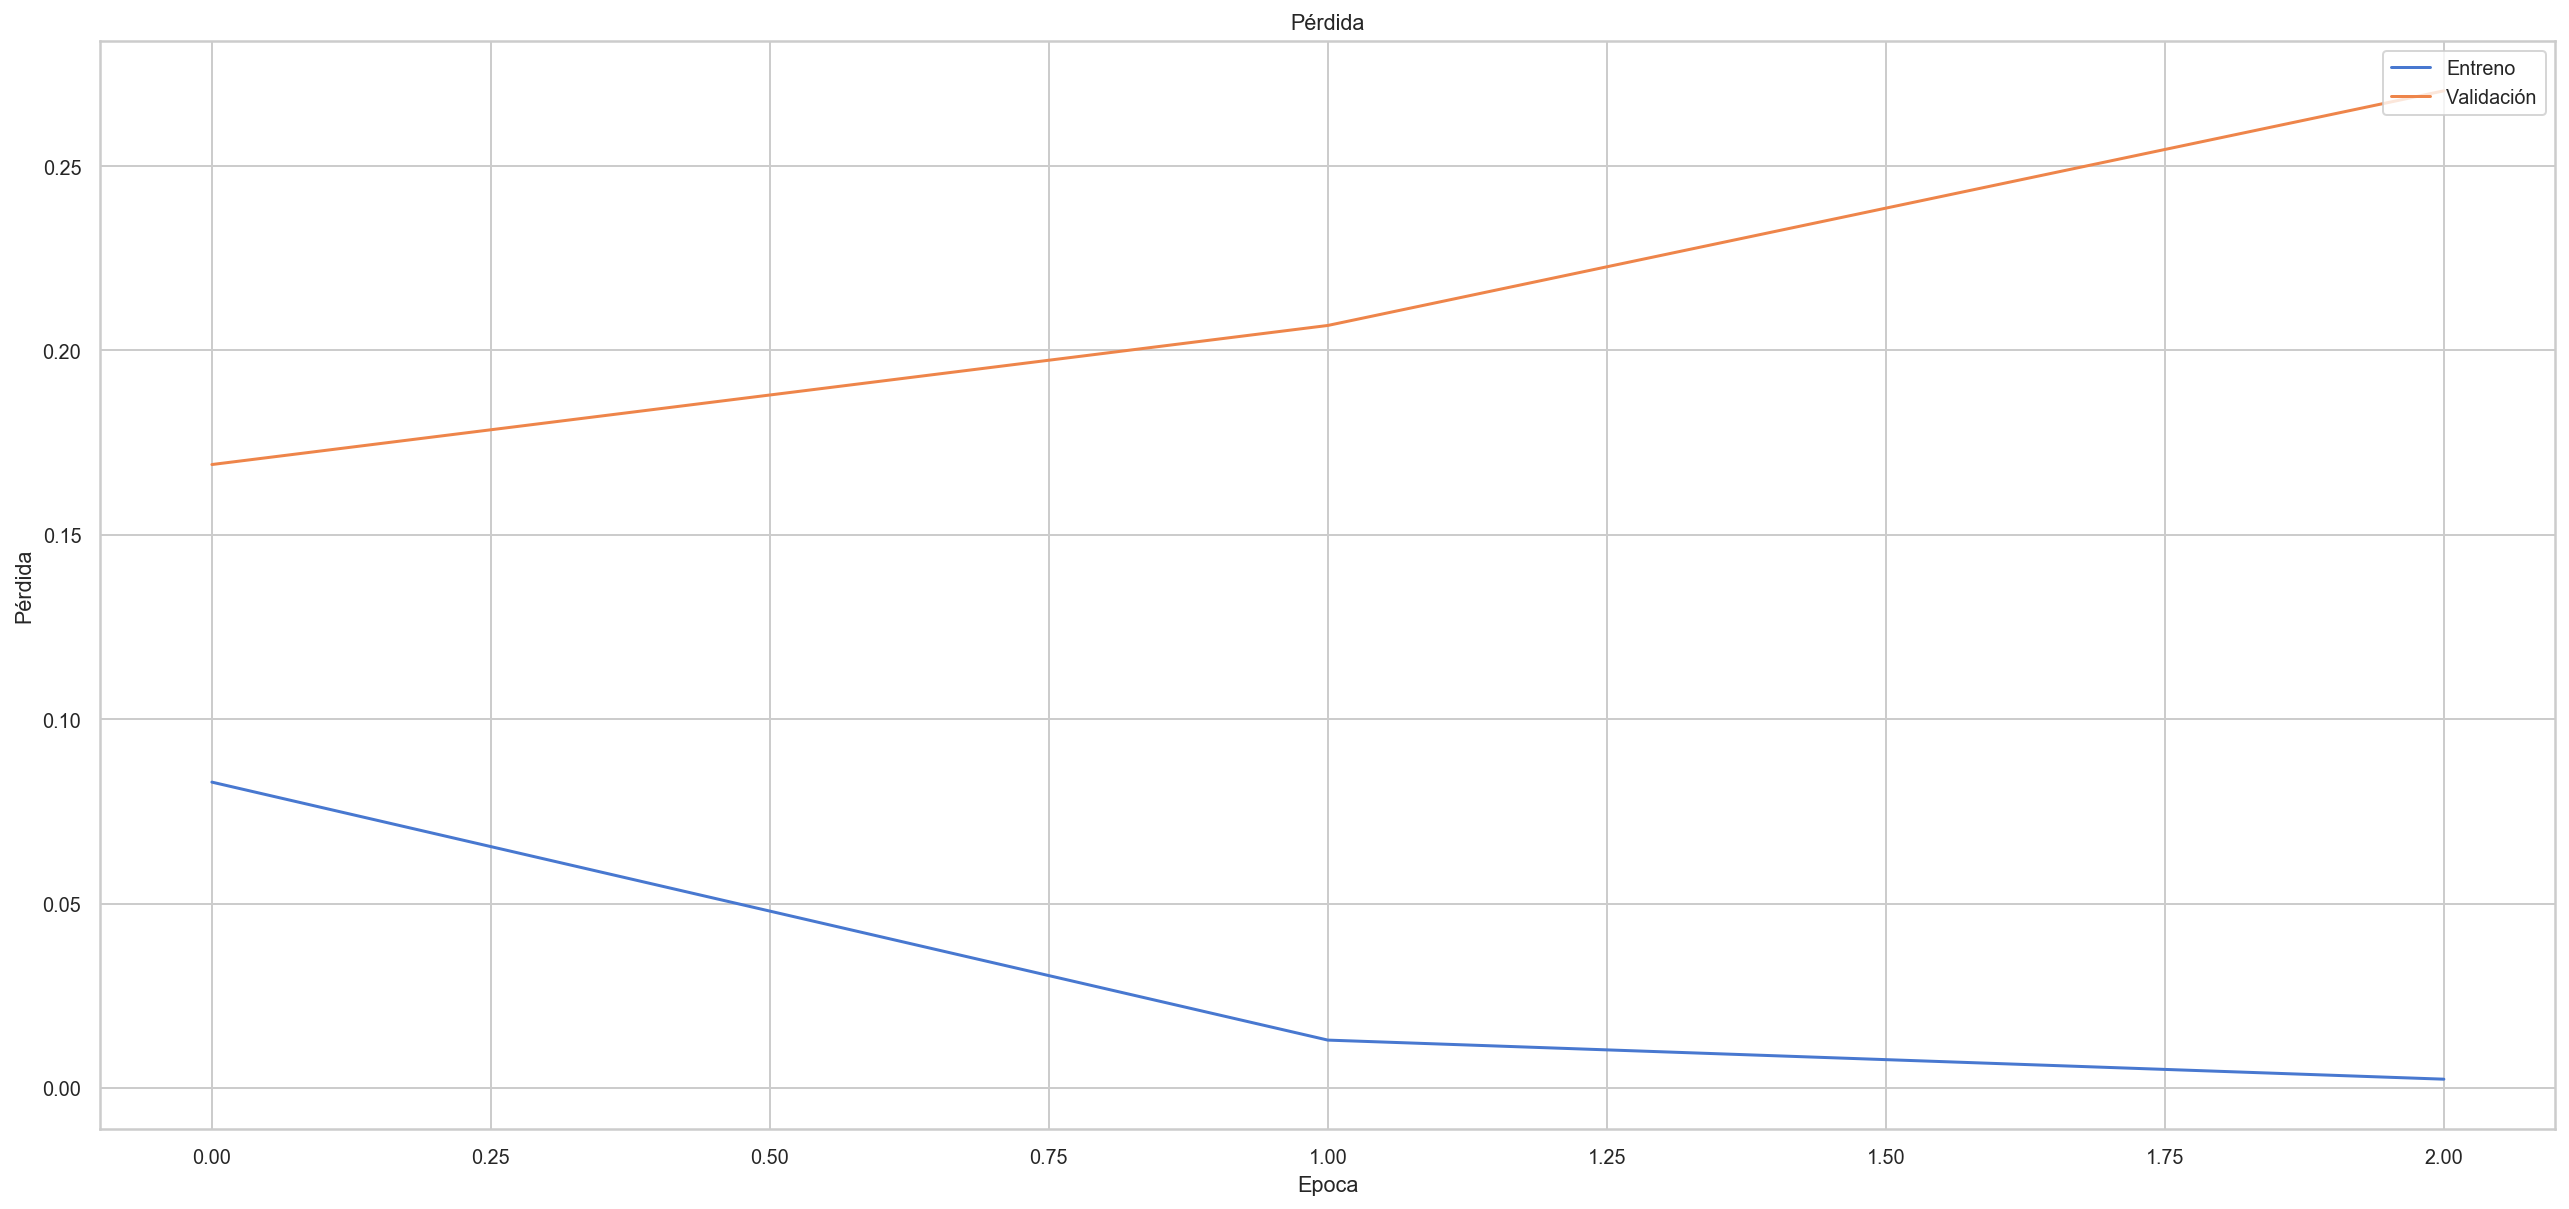

In [35]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [36]:
# B-RNN LSTM
model_urnn = load_model('URNN_part=2_seed_1.h5')

model_urnn.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [37]:
Y_predt = model_urnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))

[[11988   512]
 [  222 12278]]


In [38]:
print("Exactitud: ", model_urnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

Exactitud:  0.9706400036811829


Ahora probamos con el set de validación que siempre estuvo por fuera del entrenamiento

In [39]:
Y_predv = model_urnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))

[[10196  2304]
 [ 1503 10997]]


In [41]:
print("Exactitud: ", model_urnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

Exactitud:  0.8477200269699097


## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

In [10]:
# Input con secuencias de enteros con longitud variable
inputs_ = keras.Input(shape=(None,), dtype="int32")

In [11]:
# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x_ = layers.Embedding(max_features, 128)(inputs_)

Vamos a utilizar dos capas LSTM bidireccionales de 128 unidades, con una capa adicional de Dropout con un rate de 0.1

In [12]:
x_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x_)
x_ = layers.Bidirectional(layers.LSTM(128))(x_)
x_ = layers.Dropout(rate=0.1)(x_)

In [13]:
# Añadimos un clasificador binario en la salida
outputs_ = layers.Dense(1, activation="sigmoid")(x_)

In [14]:
# Guardamos la arquitectura del modelo
model_3 = keras.Model(inputs_, outputs_)
model_3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,217,665
Trainable params: 3,217,665
Non-trainable params: 0
_________________________________________________

In [15]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=6

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_v = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_3 = keras.Model(inputs_, outputs_)
    model_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_3.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False, batch_size = 10)
      
    # Calculamos las metricas
    train_metrics = model_3.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_3.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_3.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    #if (loss_v < err_v):
    pathr =('Custom_RNN_part='+str(i)+'_seed_'+str(r)+'.h5')
    model_3.save(pathr) 
    err_v = loss_v
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    print('Loss : loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12500 samples, validate on 12500 samples
Epoch 1/6
12500/12500 [==============================] - 339s 27ms/step - loss: 0.5585 - accuracy: 0.7045 - val_loss: 0.4207 - val_accuracy: 0.8164
Epoch 2/6
12500/12500 [==============================] - 331s 26ms/step - loss: 0.4095 - accuracy: 0.8226 - val_loss: 0.4582 - val_accuracy: 0.8212
Epoch 3/6
12500/12500 [==============================] - 5732s 459ms/step - loss: 0.2691 - accuracy: 0.8938 - val_loss: 0.4461 - val_accuracy: 0.8354
Epoch 4/6
12500/12500 [==============================] - 340s 27ms/step - loss: 0.1859 - accuracy: 0.9330 - val_loss: 0.4328 - val_accuracy: 0.8572
Epoch 5/6
12500/12500 [==============================] - 326s 26ms/step - loss: 0.1279 - accuracy: 0.9552 - val_loss: 0.4617 - val_accuracy: 0.8525
Epoch 6/6
12500/12500 [==============================] - 1276s 102ms/step - loss: 0.0818 - accuracy: 0.9728 - val

Nuestro mejor modelo presenta un accuracy sobre los datos de validación de 0.93 y sobre los de pruebas 0.85. Cargamos nuestro mejor modelo

In [16]:
# B-RNN LSTM
model_rnn = load_model('Custom_RNN_part=2_seed_1.h5')

model_rnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,217,665
Trainable params: 3,217,665
Non-trainable params: 0
_________________________________________________

In [17]:
Y_predt = model_rnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))

[[12038   462]
 [  290 12210]]


In [18]:
print("Exactitud: ", model_rnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

Exactitud:  0.9699199795722961


In [19]:
Y_predv = model_rnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))

[[10492  2008]
 [ 1719 10781]]


In [20]:
print("Exactitud: ", model_rnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

Exactitud:  0.8509200215339661


El mejor modelo obtenido, tiene un accuracy de 0.85 en el set de pruebas.